In [46]:
import pandas as pd
import datetime
from sklearn.neural_network import MLPClassifier
import random
import torch
from net import gtnet
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

In [47]:
import torch

In [48]:
# model = torch.load(f'/mnt/results/model/model_all_pop_edema_0_advweight_0_GNN_advTrue_slice0.pt')
curr_slice = 3
model = torch.load(f'/mnt/results/model/model_all_feat_0_advweight_0_indinorm_slices0_GNN_advTrue_slice0_stress.pt')
# model.state_dict


In [49]:
model.eval()
for p in model.parameters():
    print(p.nelement())

128
4
192
4
384
4
448
4
128
4
192
4
384
4
448
4
128
4
192
4
384
4
448
4
128
4
192
4
384
4
448
4
128
4
192
4
384
4
448
4
128
4
192
4
384
4
448
4
128
4
192
4
384
4
448
4
128
4
192
4
384
4
448
4
128
4
192
4
384
4
448
4
128
4
192
4
384
4
448
4
256
16
256
16
256
16
256
16
256
16
92672
32
86528
32
74240
32
49664
32
512
32
768
16
768
16
768
16
768
16
768
16
768
16
768
16
768
16
768
16
768
16
16
16
560
560
1600
40
1600
40
224
7
7
1
5984
32
512
32


In [50]:
model.idx

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
       device='cuda:0')

In [51]:
adj = model.gc(model.idx).cpu().detach().numpy()
adj = model.gc.fullA(model.idx).cpu().detach().numpy()

In [52]:
model.gc.k

5

In [53]:
model.gc.fullA(model.idx).shape

torch.Size([14, 14])

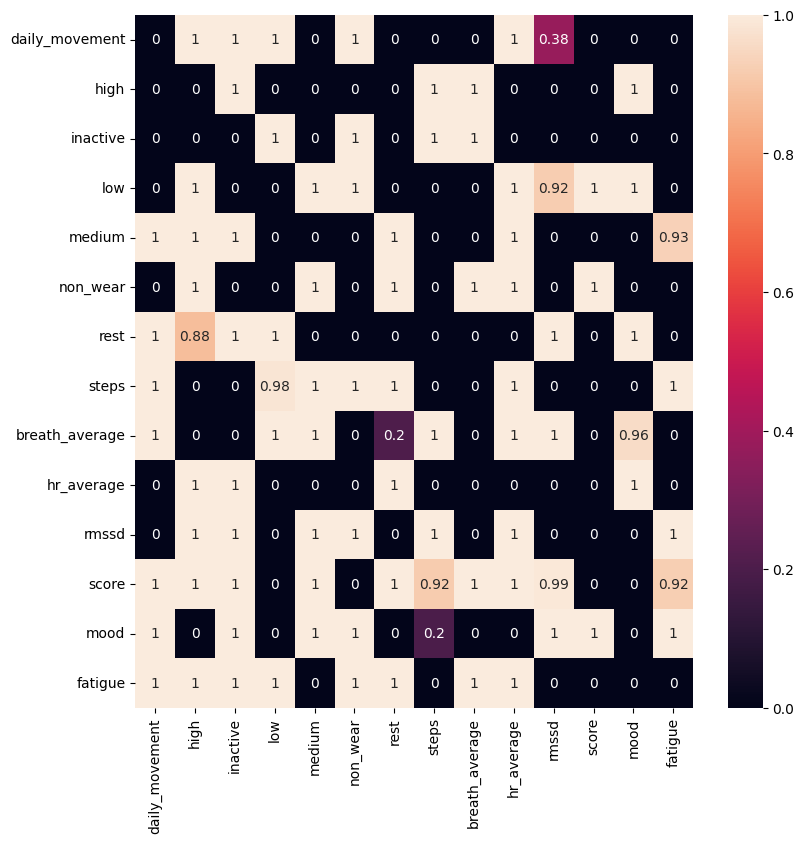

In [54]:
features = ['Active calories','Calories','Daily movement','Minutes of high-intensity activity','Minutes of inactive','Minutes of low-intensity activity','Minutes of medium-intensity activity','High-intensity MET','Inactive MET','Low-intensity MET','Medium-intensity MET','Minutes of non-wear','Minutes of rest','Total daily steps','Impedance magnitude','Impedance phase','Weight','Respiratory rate','Edema']

features = ['Impedance magnitude','Impedance phase','Weight','Calories','Daily movement','Minutes of high-intensity activity','Minutes of inactive','Minutes of low-intensity activity','Minutes of medium-intensity activity','Minutes of non-wear','Minutes of rest','Total daily steps','Respiratory rate','Edema']
features = ['daily_movement','high','inactive','low','medium','non_wear','rest','steps',
    'breath_average','hr_average','rmssd','score','mood','fatigue']
def analysis_result(mat, features):
    cm_df = pd.DataFrame(mat,   
                    index = features, 
                    columns = features)

    #Plotting the confusion matrix
    plt.figure(figsize=(9,9))
    sns.heatmap(cm_df, annot=True)
    plt.savefig('/mnt/results/plots/adj.svg')
    plt.show()
analysis_result(adj, features)

In [55]:
import argparse
import math
import time

import torch
import torch.nn as nn
from net import gtnet
import numpy as np
import importlib

from util import *
from trainer import Optim
from sequence_dataset import SequenceDataset
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader 
from model import LSTMClassifier

In [56]:
from util import *
user_dict = {84: 2, 1400: 4, 1745: 4, 2174: 3, 1453: 1, 1374: 2, 2126: 3, 159: 4, 1717: 4, 1696: 4, 604: 4, 1714: 4, 
    200: 3, 39: 1, 1989: 4, 407: 4, 2267: 4, 992: 4, 1658: 4, 47: 4, 2038: 3, 2061: 3, 2151: 3, 2102: 2, 2066: 4, 1038: 2, 
    74: 1, 28: 4, 594: 1, 2018: 1, 622: 2, 989: 3, 1743: 2, 2031: 3, 1378: 4, 185: 4, 1996: 3, 2134: 4, 186: 4, 1387: 4, 
    174: 4, 1440: 1, 2062: 2, 1724: 4, 980: 4, 2001: 4, 66: 1, 1744: 3, 234: 2, 1393: 1, 1032: 4, 1403: 3, 290: 4, 55: 3, 
    1436: 1, 291: 1, 983: 2, 122: 1, 289: 4, 1731: 3, 2109: 4, 1709: 3, 1708: 4, 1747: 4, 53: 4, 1425: 3, 969: 4, 64: 4, 
    987: 2, 581: 4, 1993: 1, 2084: 1, 1373: 2, 38: 3, 280: 1, 1426: 4, 1695: 3, 2159: 4, 2120: 2, 190: 3, 1702: 1, 137: 2, 
    1037: 4, 404: 4, 279: 1, 29: 2, 429: 2, 118: 4, 2142: 3, 2176: 2, 2056: 4, 2080: 4, 1429: 4, 1366: 3, 1988: 1, 2065: 3, 
    1712: 1, 1432: 1, 603: 2, 1976: 4, 2019: 1, 977: 4, 2113: 3, 991: 2, 1728: 2, 615: 4, 1997: 1, 1427: 2, 1367: 1, 1000: 2, 
    158: 1, 192: 3, 168: 4, 410: 1, 428: 2, 135: 2, 2015: 3, 2083: 4, 199: 2, 2058: 3, 1700: 1, 193: 3, 95: 3, 1386: 2, 2169: 3, 
    1755: 1, 2041: 4, 1369: 4, 1716: 4, 1757: 3, 1389: 4, 2212: 1, 2068: 2, 173: 4, 1985: 3, 2160: 2, 1715: 1, 2032: 3, 68: 1, 293: 1, 1750: 1, 966: 3, 1021: 2, 1697: 1, 2166: 1, 405: 1, 
    2158: 2, 2016: 1, 1431: 1, 1999: 1, 30: 2, 79: 1, 62: 1, 2076: 1, 602: 1}
train_df_lst = []
val_df_lst = []
train_dataset_lst = []
val_dataset_lst = []
device = torch.device("cuda:0")
task_name = 'stress'

train_user_label = []
val_user_label = []
list_users = []
for u in user_dict:
    # if curr_slice >= user_dict[u]: # not available for this user
    #     continue
    
    file_name = f'/mnt/dataset/{task_name}/user_{u}_{task_name}_hyperimpute_slice{curr_slice}.csv'

    try:
        curr_all_data = np.loadtxt(file_name, delimiter=',')# [:, :-1] # exclude edema coarse label for now
        list_users.append(u)
    except OSError:
        continue



    

    
    # print(u)
    num_all_data, _ = curr_all_data.shape
    # val_split_idx = int(num_all_data * 0.6)
    # test_split_idx = int(num_all_data * 0.8)
    val_split_idx = 14
    test_split_idx = 14

    val_split_idx -= args.seq_in_len
    test_split_idx -= args.seq_in_len

    # test is the same as val for now
    curr_train_data = curr_all_data[:val_split_idx, :].copy()
    curr_val_data = curr_all_data[val_split_idx:, :].copy()
    # curr_val_data = curr_all_data[val_split_idx:test_split_idx, :]
    curr_test_data = curr_all_data[test_split_idx:, :].copy()

    # print(curr_all_data.shape)
    previous_data_file_name = f'/mnt/dataset/{task_name}/user_{u}_{task_name}_slice{curr_slice-1}.csv'
    if os.path.exists(previous_data_file_name):
        print(curr_train_data.shape)
        prev_data = np.loadtxt(previous_data_file_name, delimiter=',')[-args.seq_in_len:, :-1]
        curr_train_data = np.concatenate((prev_data, curr_train_data), axis=0)
        print(curr_train_data.shape)


    curr_train_data[:, -1] = curr_train_data[:, -1].astype(int)
    curr_val_data[:, -1] = curr_val_data[:, -1].astype(int)
    curr_test_data[:, -1] = curr_test_data[:, -1].astype(int)
    
    # print(curr_train_data.shape)
    # print(curr_val_data.shape)
    # print(curr_test_data.shape)

    train_df_lst.append(curr_train_data)
    val_df_lst.append(curr_val_data)
    test_df_lst.append(curr_test_data)

# normalization

# over all population


# normalized_train_df_lst, min_value_lst, max_value_lst = min_max_normalization(train_df_lst)
# normalized_val_df_lst, _, _ = min_max_normalization(val_df_lst, min_value_lst=min_value_lst, max_value_lst=max_value_lst)
# normalized_test_df_lst, _, _ = min_max_normalization(test_df_lst, min_value_lst=min_value_lst, max_value_lst=max_value_lst)
# print(normalized_train_df_lst[8][:, -1])
# return

# over each individual, use only first 2 week data
normalized_train_df_lst = []
normalized_val_df_lst = []
normalized_test_df_lst = []
for i in range(len(list_users)):
    curr_train_data = train_df_lst[i]
    curr_val_data = val_df_lst[i]
    curr_test_data = test_df_lst[i]

    first_two_week = curr_train_data[:15, :]
    rest = curr_train_data[15:, :]
    curr_train_data[:, -1] = curr_train_data[:, -1].astype(int)
    curr_val_data[:, -1] = curr_val_data[:, -1].astype(int)
    curr_test_data[:, -1] = curr_test_data[:, -1].astype(int)
    

    normalized_first_two_week, min_value_lst, max_value_lst = min_max_normalization([first_two_week])
    normalized_rest, _, _ = min_max_normalization([rest], min_value_lst=min_value_lst, max_value_lst=max_value_lst)

    normalized_val, _, _ = min_max_normalization([curr_val_data], min_value_lst=min_value_lst, max_value_lst=max_value_lst)
    normalized_test, _, _ = min_max_normalization([curr_test_data], min_value_lst=min_value_lst, max_value_lst=max_value_lst)

    normalized_train = np.concatenate((normalized_first_two_week, normalized_rest), axis=0)
    
    normalized_train_df_lst.append(normalized_train)
    # print(normalized_train[:, -1])
    
    if np.sum(np.isnan(normalized_train)) > 0:
        print(list_users[i])

    normalized_val_df_lst.append(normalized_val)
    
    normalized_test_df_lst.append(normalized_test)




# create sequential datasets
for count, curr_train_data in enumerate(normalized_train_df_lst):
    curr_train_dataset = SequenceDataset(curr_train_data, args.horizon, args.seq_in_len, device, user_id=count)
    train_dataset_lst.append(curr_train_dataset)
for count, curr_val_data in enumerate(normalized_val_df_lst):
    curr_val_dataset = SequenceDataset(curr_val_data, args.horizon, args.seq_in_len, device, user_id=count)
    val_dataset_lst.append(curr_val_dataset)
for count, curr_test_data in enumerate(normalized_test_df_lst):
    curr_test_dataset = SequenceDataset(curr_test_data, args.horizon, args.seq_in_len, device, user_id=count)
    test_dataset_lst.append(curr_test_dataset)

# aggregate them
aggregated_train_dataset = ConcatDataset(train_dataset_lst)
aggregated_val_dataset = ConcatDataset(val_dataset_lst)
aggregated_test_dataset = ConcatDataset(test_dataset_lst)

train_dataloader = DataLoader(aggregated_train_dataset, batch_size=args.batch_size, shuffle=True)
val_dataloader = DataLoader(aggregated_val_dataset, batch_size=args.batch_size, shuffle=False)
test_dataloader = DataLoader(aggregated_test_dataset, batch_size=args.batch_size, shuffle=False)

NameError: name 'args' is not defined

In [57]:
num_val_data

74

In [58]:
from typing import Dict, Iterable, Callable

class FeatureExtractor(nn.Module):
    def __init__(self, model, layers):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}

        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.save_outputs_hook(layer_id))

    def save_outputs_hook(self, layer_id):
        def fn(_, __, output):
            self._features[layer_id] = output
        return fn

    def forward(self, x):
        _ = self.model(x)
        return self._features

In [59]:
# args = {'data': '/mnt/results/user_1431_activity_bodyport_hyperimpute.csv', 'log_interval': 2000, 'save': '/mnt/results/model/model_all_pop_edema_0_GNN.pt', 'optim': 'adam', 'L1Loss': True, 'normalize': 0, 'device': 'cuda:0', 'gcn_true': True, 'buildA_true': True, 'gcn_depth': 2, 'num_nodes': 21, 'dropout': 0.3, 'subgraph_size': 21, 'node_dim': 40, 'dilation_exponential': 2, 'conv_channels': 16, 'residual_channels': 16, 'skip_channels': 32, 'end_channels': 64, 'in_dim': 1, 'seq_in_len': 7, 'seq_out_len': 1, 'horizon': 1, 'layers': 5, 'batch_size': 32, 'lr': 0.0001, 'weight_decay': 1e-05, 'clip': 5, 'propalpha': 0.05, 'tanhalpha': 3, 'epochs': 50, 'num_split': 1, 'step_size': 100}
# model = gtnet(args['gcn_true'], args['buildA_true'], args['gcn_depth'], args['num_nodes'],
#                     device, dropout=args['dropout'], subgraph_size=args['subgraph_size'],
#                     node_dim=args['node_dim'], dilation_exponential=args['dilation_exponential'],
#                     conv_channels=args['conv_channels'], residual_channels=args['residual_channels'],
#                     skip_channels=args['skip_channels'], end_channels= args['end_channels'],
#                     seq_length=args['seq_in_len'], in_dim=args['in_dim'], out_dim=args['seq_out_len'],
#                     layers=args['layers'], propalpha=args['propalpha'], tanhalpha=args['tanhalpha'], layer_norm_affline=False)
# torch.load(f'/mnt/results/model/model_all_pop_edema_0_GNN.pt')

In [60]:
gtnet_features = FeatureExtractor(model, layers=["end_conv_1"])
output_lst = []
edema_lst = []
input_lst = []
for batch_data in dataloader:
    X = batch_data['X'].to(device)
    Y = batch_data['Y'].to(device)
    feature_size = X.shape[-1]

    X = torch.unsqueeze(X,dim=1)
    X = X.transpose(2,3)
    edema_label = Y[:, -1].unsqueeze(-1).cpu().detach().numpy()
    edema_lst.append(edema_label)
    
    with torch.no_grad():
        output = gtnet_features(X)['end_conv_1']
        print(output.shape)
        output_lst.append(output.squeeze(-1).view(output.shape[0], -1).cpu().detach().numpy())
        input_lst.append(X.squeeze(-1).reshape(X.shape[0], -1).cpu().detach().numpy())
    

AssertionError: input sequence length not equal to preset sequence length

In [61]:
edema_lst = np.concatenate(edema_lst)


In [62]:

all_embeddings = np.concatenate(output_lst, axis=0)
# all_embeddings = np.concatenate(input_lst, axis=0)

ValueError: need at least one array to concatenate

In [63]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)
    # tsne_results = tsne.fit_transform(pca_result)
tsne_results = tsne.fit_transform(all_embeddings)

NameError: name 'all_embeddings' is not defined

In [64]:
df_tsne = pd.DataFrame(tsne_results, columns=["X", "Y"])

df_tsne["User_labels"] = all_user_label
df_tsne["User_labels"] = df_tsne["User_labels"].apply(lambda i: str(i))

df_tsne["Training_set"] = [True] * num_train_data + [False] * num_val_data
markers_dict = {
    True: 'o',
    False: 'X',
}
df_tsne["Edema_label"] = edema_lst
fig, axs = plt.subplots(ncols=2, figsize=(12, 12))
# plt.figure(figsize=(16,16))
axs[0].set(ylim=(-25, 25))
axs[0].set(xlim=(-25, 25))
axs[1].set(ylim=(-25, 25))
axs[1].set(xlim=(-25, 25))
sns.scatterplot(
    x="X", y="Y",
    hue="User_labels",
    style="Training_set",
    data=df_tsne,
    legend="full", s=70,
    alpha=0.9,
    markers=markers_dict,
    ax=axs[0]
)

# plt.savefig('/mnt/results/plots/embedding_no_labels.svg')


sns.scatterplot(
    x="X", y="Y",
    hue="Edema_label",
    style="Training_set",
    data=df_tsne,
    legend="full", s=70,
    alpha=0.9,
    markers=markers_dict,
    ax=axs[1]
)

NameError: name 'tsne_results' is not defined

In [65]:

plt.savefig('/mnt/results/plots/embedding_with_labels.svg')

<Figure size 640x480 with 0 Axes>